# Summary
In this notebook we create plots for the following comparisons:
* LFY ChIP-Seq (Jin 2021) vs LFY ChIP-chip (Winter 2011)
* FD ChIP-Seq (Zhu 2020) vs FD ChIP-Seq (Collani 2019)

We will compare different parameters given a LFY summit q-value <= 10^-10 and then compare different LFY summit q-value parameters.

# Set up Environment
get libraries

In [96]:
import pandas as pd
import numpy as np
import os

# plotting libraries
from plotnine import *
%matplotlib inline

# LFY ChIP

import table of data

In [97]:
lfy_pooled_df = pd.read_csv("../data/lfy_pooled_chipComparisons.tsv",sep="\t")
lfy_pooled_df

,samples,mask_ultrahigh_signals,control,dups,log10_summit_qvalue,total,peaksOverlap_GS,peaksOverlap_LFYChIPchip,peaksOverlap_LFYChIPchip_and_GS
0,LFY,noScreen,none,True,10,2383,147,723,0
1,LFY,noScreen,Input,True,10,1755,67,712,0
2,LFY,noScreen,Mock,True,10,1003,0,557,0
3,LFY,GS,Input,True,10,1688,0,712,0
4,LFY,BL,Input,True,10,1635,0,697,0
5,LFY,noScreen,Input,False,10,1293,60,633,0
6,LFY,noScreen,Input,True,2,8574,109,988,0
7,LFY,noScreen,Input,True,5,4273,96,890,0
8,LFY,noScreen,Input,True,20,927,35,518,0
9,LFY,noScreen,Input,True,30,666,25,418,0


Add columns and change values of specific columns. This will be useful for labeling the plots downstream.

In [128]:
def decorate(pooled_df):

    # instead of True and False for the "dups" column
    # I want to have strings "wiDups" or "noDups"
    # respectively
    pooled_df["dups"] = \
        pooled_df["dups"].replace(
            [True, False],
            ["wiDups","noDups"])

    # replace Control strings
    pooled_df["control"] = \
        pooled_df["control"].replace(
            ["none", "Input", "Mock"],
            ["noControl","inputControl","mockControl"])

    # create a column that includes 
    # the total number of peaks as well
    # as the following parameters:
    # * duplicates included (wiDups/noDups)
    # * MACS2 control: none, inputControl, mockControl
    # * mask: noScreen, GS, BL
    pooled_df['dups_control_gs_total']= \
        pooled_df.agg(
            lambda x: f"n={x['total']}\n\n{x['dups']},\n{x['control']}\n{x['mask_ultrahigh_signals']}", axis=1)
    
    # create a column that includes 
    # the total number of peaks as well
    # as the log10 summit q-value
    # threshold
    pooled_df['qval10_total']= \
        pooled_df.agg(
            lambda x: f"{x['log10_summit_qvalue']}\n[n={x['total']}]", axis=1)
    
    return(pooled_df)

In [129]:
lfy_pooled_df = decorate(lfy_pooled_df)

plot values in a stacked bar chart

In [130]:
def plotOverlapStackedBarChart_V3(pool_df,
                                  gs_overlap_col,
                                  samp_overlap_col,
                                  plot_title,
                                  xaxis,xlabels,
                                 axis_font_size=3):
    
    # melt table to give overlap count values for each
    # set of parameters
    cats_of_interest=[gs_overlap_col, samp_overlap_col]
    
    pool_melted_df = pd.melt(pool_df,
        id_vars=[xlabels],
        value_vars=cats_of_interest)
    pool_melted_df["variable_cat"] = \
        pd.Categorical(pool_melted_df['variable'], 
                       categories=cats_of_interest)
    # specify order of x-axis
    pool_melted_df2 = pool_melted_df.reset_index()
    pool_melted_df2[xlabels] = (
        pd.Categorical(pool_melted_df2[xlabels], 
                       categories=pd.unique(pool_melted_df2[xlabels])))
    # generate plot using plotnine library
    pool_plot = (ggplot(
        pool_melted_df2, 
        aes(x=xlabels, y='value', 
            fill='variable_cat')) + 
        geom_bar(stat='identity', position='stack') + 
        labs(title=plot_title,
              y="Number of Peaks",
              x=xaxis,fill="") + 
         theme(title = element_text(size=14),
               axis_text_x=element_text(size=axis_font_size),
               axis_text_y=element_text(size=axis_font_size),
              strip_background = element_blank(),
              strip_margin=0,
              strip_margin_x=0.4,
              strip_margin_y=0.4,
              legend_position=(.5,-.15),
              legend_direction = "horizontal",
              panel_background=element_blank(),
              axis_line = element_line(size=1, colour = "black"),
              panel_grid_major = element_line(colour = "#d3d3d3")) +
        geom_text(aes(label='value'), size = 20, position = position_stack(vjust = 0.5))
    )
    return(pool_plot)

first we compare multiple parameters at once by seting a summit q-value threshold of 10^-10

In [131]:
lfy_qval10_pooled_df = lfy_pooled_df.loc[(
    lfy_pooled_df["log10_summit_qvalue"] == 10),:]

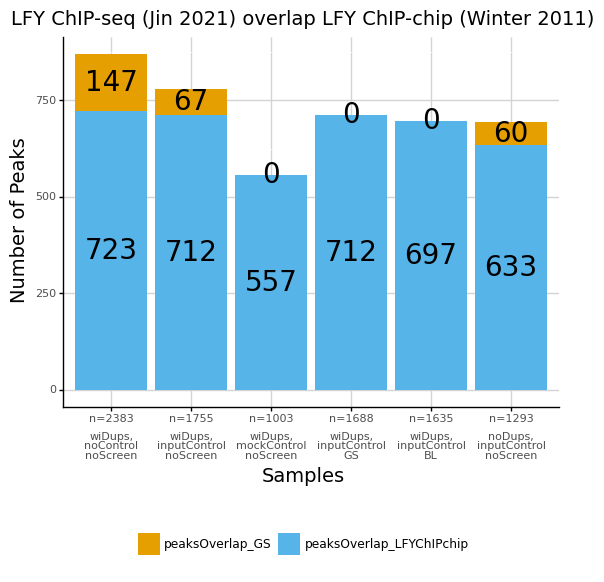

<ggplot: (8779740689454)>

In [132]:
plot=(plotOverlapStackedBarChart_V3(lfy_qval10_pooled_df,
                           "peaksOverlap_GS",
                           "peaksOverlap_LFYChIPchip",
                           "LFY ChIP-seq (Jin 2021) overlap LFY ChIP-chip (Winter 2011)",
                            "Samples",
                            "dups_control_gs_total",8) + 
                 scale_fill_manual(values=["#E69F00", "#56B4E9"])
)
plot

Now we test the summit q-value threshold by maintaining the following parameters:
* wiDups
* Input Control
* noScreen

In [133]:
# filter rows
lfy_testSummitQval_pooled_df = lfy_pooled_df.loc[(
    (lfy_pooled_df["dups"] == "wiDups") &
    (lfy_pooled_df["control"] == "inputControl") &
    (lfy_pooled_df["mask_ultrahigh_signals"] == "noScreen")),:].copy()

# sort
lfy_testSummitQval_pooled_df = (
    lfy_testSummitQval_pooled_df.sort_values(
        by=["log10_summit_qvalue"]).reset_index(drop=True))

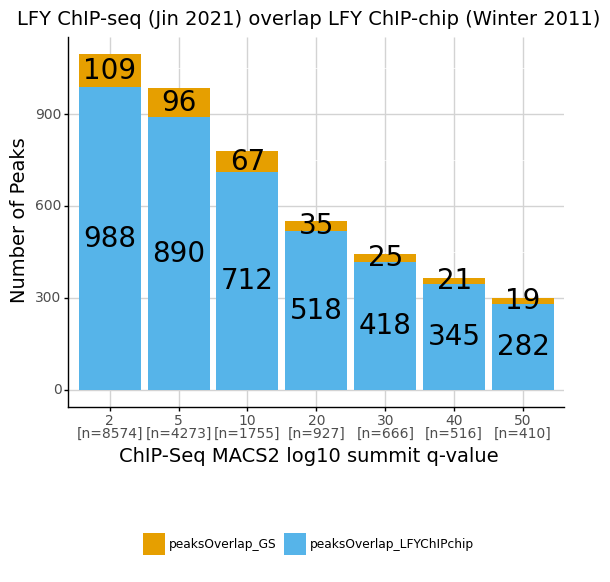

<ggplot: (8779740519702)>

In [135]:
plot=(plotOverlapStackedBarChart_V3(lfy_testSummitQval_pooled_df,
                           "peaksOverlap_GS",
                           "peaksOverlap_LFYChIPchip",
                           "LFY ChIP-seq (Jin 2021) overlap LFY ChIP-chip (Winter 2011)",
                            "ChIP-Seq MACS2 log10 summit q-value",
                            "qval10_total",10) + 
                 scale_fill_manual(values=["#E69F00", "#56B4E9"])
)
plot

# FD ChIP

import table of data

In [136]:
fd_pooled_df = pd.read_csv("../data/fd_pooled_chipComparisons.tsv",sep="\t")
fd_pooled_df

,samples,mask_ultrahigh_signals,control,dups,log10_summit_qvalue,total,peaksOverlap_GS,peaksOverlap_FDSchmid,peaksOverlap_FDSchmid_and_GS
0,FD,noScreen,none,True,10,5047,104,3452,0
1,FD,noScreen,Input,True,10,5276,43,3644,0
2,FD,noScreen,Mock,True,10,4258,1,3194,0
3,FD,GS,Input,True,10,5233,0,3644,0
4,FD,BL,Input,True,10,5291,0,3678,0
5,FD,noScreen,Input,False,10,4420,9,3265,0
6,FD,noScreen,Input,True,2,8504,45,4517,0
7,FD,noScreen,Input,True,5,7392,45,4338,0
8,FD,noScreen,Input,True,20,3700,32,2881,0
9,FD,noScreen,Input,True,30,2961,26,2428,0


In [137]:
fd_pooled_df = decorate(fd_pooled_df)
fd_qval10_pooled_df = fd_pooled_df.loc[(
    fd_pooled_df["log10_summit_qvalue"] == 10),:]

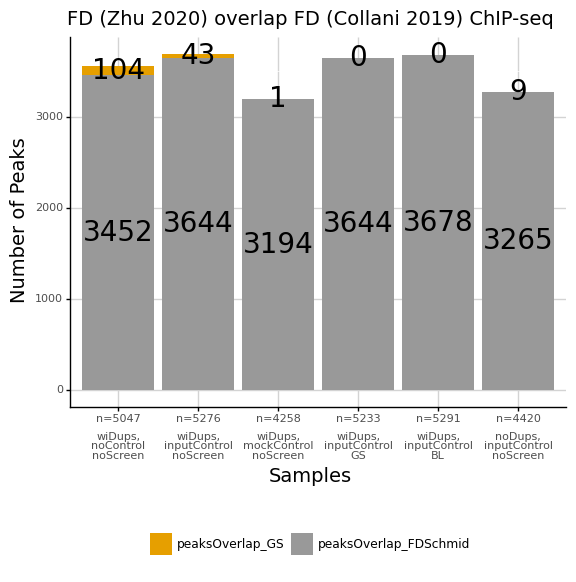

<ggplot: (8779740518635)>

In [142]:
plot=(plotOverlapStackedBarChart_V3(fd_qval10_pooled_df,
                           "peaksOverlap_GS",
                           "peaksOverlap_FDSchmid",
                           "FD (Zhu 2020) overlap FD (Collani 2019) ChIP-seq",
                            "Samples",
                            "dups_control_gs_total",8) + 
                 scale_fill_manual(values=["#E69F00", "#999999"])
)
plot

Now we test the summit q-value threshold by maintaining the following parameters:
* wiDups
* Input Control
* noScreen

In [139]:
# filter rows
fd_testSummitQval_pooled_df = fd_pooled_df.loc[(
    (fd_pooled_df["dups"] == "wiDups") &
    (fd_pooled_df["control"] == "inputControl") &
    (fd_pooled_df["mask_ultrahigh_signals"] == "noScreen")),:].copy()

# sort
fd_testSummitQval_pooled_df = (
    fd_testSummitQval_pooled_df.sort_values(
        by=["log10_summit_qvalue"]).reset_index(drop=True))

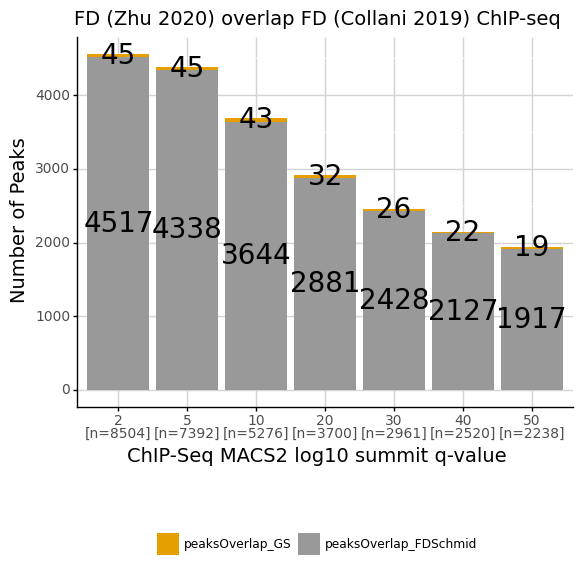

<ggplot: (8779740627176)>

In [140]:
plot=(plotOverlapStackedBarChart_V3(fd_testSummitQval_pooled_df,
                           "peaksOverlap_GS",
                           "peaksOverlap_FDSchmid",
                           "FD (Zhu 2020) overlap FD (Collani 2019) ChIP-seq",
                            "ChIP-Seq MACS2 log10 summit q-value",
                            "qval10_total",10) + 
                 scale_fill_manual(values=["#E69F00", "#999999"])
)
plot